## To do
- Try extra trees on location based dataset

## Done
- compared a single decision tree on both full mutation and location based datasets, results are the same
- sort the aa based on BLOSUM62 and check the random forest
- create aa swap based dataset and run decision tree on it
- Do a parameter grid search on Random Forest on location and mutation based dataset

In [70]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from scipy import sparse 
import seaborn as sns
sns.set(rc={'axes.facecolor':'#F5F5F5'})
%matplotlib inline

from sklearn.model_selection import KFold,cross_val_score
from sklearn.model_selection import StratifiedShuffleSplit,StratifiedKFold
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,ExtraTreesClassifier
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler,MinMaxScaler,maxabs_scale
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC,NuSVC,SVR,NuSVR
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn import neighbors
from sklearn.decomposition import TruncatedSVD

from time import time

----------------------------------------------------------------------------------------------------------------------

# Importing data

In [2]:
# Function to load csr matrix of samples and list of colnames from file
def load_csr_from_csv(filename):
    indices = np.loadtxt(filename+"_indices.csv",unpack=True,delimiter=",")
    indptr = np.loadtxt(filename+"_indptr.csv",unpack=True,delimiter=",")
    shape = np.loadtxt(filename+"_shape.csv",unpack=True,delimiter=",")
    col_names = np.loadtxt(filename+"_col_names.csv",unpack=True,delimiter=",",dtype=str)
    data = np.ones_like(indices,dtype=np.int8)
    
    return sparse.csr_matrix((data, indices, indptr),
                         shape = shape),col_names

In [3]:
# returns the csr matrix of samples and list of colnames
def load_csr_from_csv_with_data(filename):
    data = np.loadtxt(filename+"_data.csv",unpack=True,delimiter=",",dtype=np.int8)
    indices = np.loadtxt(filename+"_indices.csv",unpack=True,delimiter=",")
    indptr = np.loadtxt(filename+"_indptr.csv",unpack=True,delimiter=",")
    shape = np.loadtxt(filename+"_shape.csv",unpack=True,delimiter=",")
    col_names = np.loadtxt(filename+"_col_names.csv",unpack=True,delimiter=",",dtype=str)
    
    return sparse.csr_matrix((data, indices, indptr),
                         shape = shape),col_names

In [4]:
# load the target values of brightness and create a binary vector 
# with 1 for samples with brightness above threshold and 0 otherwise
y,std = np.loadtxt("target_values.csv",unpack=True,delimiter=",")

threshold = 0.95 #threshold for target values

y_bin = np.where(y >= y[0]*threshold,1,0) # binary respresentation of target values based on threshold

class_weights = (y_bin.sum()*1./(y_bin.shape[0]-y_bin.sum())*1.,1.)
 
print "Total number of mutants: %d"%y.shape[0]
print "Fraction of positive samples: %.2f"%(y_bin.sum()*1./y_bin.shape[0])

Total number of mutants: 54025
Fraction of positive smaples: 0.34


In [6]:
sample_weights = np.loadtxt("sample_weights.csv",delimiter=",")
sample_weights = np.log10(sample_weights*10)
sample_weights = (sample_weights/sample_weights.max()).reshape(-1)

In [8]:
# Load the full mutation list dataset with column names from file
X, col_names = load_csr_from_csv("sparse_csr")
print X.shape

(54025, 1879)


In [150]:
# load blossum-based data
t1 = time()
X_blosum, cols = load_csr_from_csv_with_data("loc_blosum")
print "Reading sparse matrix from file took %0.2f seconds.\n"%(time()-t1);

Reading sparse matrix from file took 2.10 seconds.



In [14]:
#Rescaling data to [0,1]
X_blosum_scaled = maxabs_scale(X_blosum)

In [30]:
# Retrieve all the mutants with single mutations 
# and create the look up table for this single mutations
single_mutations = {}
single_mut_idx = []

for i in xrange(X.shape[0]):
    if X.getrow(i).indices.shape[0] == 1: #how many mutations in this mutant? one?
        index = X.getrow(i).indices[0]
        mutation = col_names[index]
#         print mutation, i
        if mutation not in single_mutations:
            single_mutations[mutation] = {"id":index,"mutants":[i]}
            single_mut_idx.append(i)
        else:
            single_mutations[mutation]["mutants"].append(i)

In [31]:
print "Total number of single mutation mutants: %d" % len(single_mut_idx)

Total number of single mutation mutants: 1114


----------------------------------------------------------------------------------------------------------------------

# Training Random Forest Classifier

<div class="alert alert-success">Location + blosum based dataset</div>

In [32]:
print "Performing parameter grid search on Random Forest..."
t1 = time()
clf = RandomForestClassifier(n_estimators=30, class_weight={0:class_weights[0], 1:class_weights[1]})
#print rf.get_params()
parameters = {"max_features":(10,), "min_samples_split":(50,100)}
clf = GridSearchCV(clf, parameters,cv = 5,n_jobs=-1)
clf.fit(X_blosum_scaled,y_bin)
print "Time taken: %.2f" % (time()-t1)

Performing parameter grid search on Random Forest...
Time taken: 19.65


In [33]:
#printing the results of grid search
print clf.best_params_,clf.best_score_
cv_results = pd.DataFrame(clf.cv_results_)
cv_results.sort_values(by="rank_test_score").sort_values(by="rank_test_score")
cv_results[['params',"mean_train_score","mean_test_score","std_test_score",'rank_test_score','mean_fit_time']].sort_values(by="rank_test_score")

{'max_features': 10, 'min_samples_split': 50} 0.820694123091


,params,mean_train_score,mean_test_score,std_test_score,rank_test_score,mean_fit_time
0,"{u'max_features': 10, u'min_samples_split': 50}",0.925761,0.820694,0.008667,1,8.395274
1,"{u'max_features': 10, u'min_samples_split': 100}",0.894327,0.819232,0.008481,2,5.071479


In [34]:
# Running cross validation on Random Forest using cross-validation
cv = StratifiedKFold(n_splits=5)
clf = RandomForestClassifier(n_estimators=30,max_features= 10,min_samples_split=50,class_weight={0:class_weights[0],1:class_weights[1]})
scores = cross_val_score(clf, X_blosum_scaled, y_bin, cv=cv,fit_params={'sample_weight':sample_weights},n_jobs=-1)

In [35]:
# printing the results of cross-validation
print scores
print("Accuracy: %0.2f (+/- %0.3f)" % (scores.mean(), scores.std() * 2))

[ 0.82704053  0.81545581  0.83146691  0.81601111  0.80831174]
Accuracy: 0.82 (+/- 0.017)


In [36]:
# Train the classifier on the full dataset
clf = RandomForestClassifier(n_estimators=30,max_features=10,min_samples_split=50,class_weight={0:class_weights[0],1:class_weights[1]})
clf.fit(X_blosum_scaled,y_bin,sample_weight = sample_weights)

RandomForestClassifier(bootstrap=True,
            class_weight={0: 0.51632097448707515, 1: 1.0},
            criterion='gini', max_depth=None, max_features=10,
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=50,
            min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [37]:
yhat = clf.predict(X_blosum_scaled)
print "Training accuracy: %.2f"%metrics.accuracy_score(y_bin,yhat,sample_weight = sample_weights)

Training accuracy: 0.93


<div class = "alert alert-danger" style = "border-radius:10px">Best parameters so far: <i>n_estimators=30, max_features= 10, min_samples_split=50</i></div>

----------------------------------------------------------------------------------------------------------------------

<div class="alert alert-success">Mutation based dataset</div>

In [54]:
print "Performing parameter grid search on Random Forest..."
t1 = time()
clf = RandomForestClassifier(n_estimators=30,class_weight={0:class_weights[0],1:class_weights[1]})
#print rf.get_params()
parameters = {"max_features":(5,10),"min_samples_split":(100,)}
clf = GridSearchCV(clf, parameters,cv = 5,fit_params={'sample_weight':sample_weights},n_jobs=-1)
clf.fit(X,y_bin)
print "Time taken: %.2f"%(time()-t1)

Performing parameter grid search on Random Forest...
Time taken: 15.58


In [55]:
print clf.best_params_,clf.best_score_
cv_results = pd.DataFrame(clf.cv_results_)
cv_results.sort_values(by="rank_test_score")
cv_results[['params',"mean_train_score","mean_test_score","std_test_score",'rank_test_score','mean_fit_time']].sort_values(by="rank_test_score")

{'max_features': 5, 'min_samples_split': 100} 0.836112910689


,params,mean_train_score,mean_test_score,std_test_score,rank_test_score,mean_fit_time
0,"{u'max_features': 5, u'min_samples_split': 100}",0.899255,0.836113,0.009742,1,5.575208
1,"{u'max_features': 10, u'min_samples_split': 100}",0.895595,0.831226,0.008812,2,5.740653


In [56]:
# cross validation using top 
cv = StratifiedKFold(n_splits=5)
clf = RandomForestClassifier(n_estimators=30,max_features=10,min_samples_split=50,class_weight={0:class_weights[0],1:class_weights[1]})
#print clf.get_params()
scores = cross_val_score(clf, X, y_bin, cv=cv,fit_params={'sample_weight':sample_weights})

In [57]:
print scores
print("Accuracy: %0.2f (+/- %0.3f)" % (scores.mean(), scores.std() * 2))

[ 0.84018138  0.82832022  0.83868579  0.81850995  0.83404295]
Accuracy: 0.83 (+/- 0.016)


In [58]:
# train the classifer using full data set
clf = RandomForestClassifier(n_estimators=30,min_samples_split=50,max_features=10,class_weight={0:class_weights[0],1:class_weights[1]})
print clf.fit(X,y_bin,sample_weight = sample_weights)

RandomForestClassifier(bootstrap=True,
            class_weight={0: 0.51632097448707515, 1: 1.0},
            criterion='gini', max_depth=None, max_features=10,
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=50,
            min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


In [59]:
yhat = clf.predict(X)
print "Training accuracy: %.2f"%metrics.accuracy_score(y_bin,yhat,sample_weight = sample_weights)

Training accuracy: 0.93


----------------------------------------------------------------------------------------------------------------------

<div class="alert alert-success">Extra trees classifier (with blossum)</div>

In [60]:
print "Performing parameter grid search on Extra trees Classifier..."
t1 = time()
clf = ExtraTreesClassifier(n_estimators=30,class_weight={0:class_weights[0],1:class_weights[1]})
#print rf.get_params()
parameters = {"max_features":(10,"auto"),"min_samples_split":(50,)}
clf = GridSearchCV(clf, parameters,cv = 5,n_jobs=-1)#,fit_params={'sample_weight':sample_weights})
clf.fit(X_blosum_scaled,y_bin)
print "Time taken: %.2f"%(time()-t1)

Performing parameter grid search on Extra trees Classifier...
Time taken: 34.52


In [62]:
print clf.best_params_,clf.best_score_
cv_results = pd.DataFrame(clf.cv_results_)
cv_results.sort_values(by="rank_test_score").sort_values(by="rank_test_score")
cv_results[['params',"mean_train_score","mean_test_score","std_test_score",'rank_test_score','mean_fit_time']].sort_values(by="rank_test_score")

{'max_features': 10, 'min_samples_split': 50} 0.814086071263


,params,mean_train_score,mean_test_score,std_test_score,rank_test_score,mean_fit_time
0,"{u'max_features': 10, u'min_samples_split': 50}",0.948292,0.814086,0.011345,1,12.838986
1,"{u'max_features': u'auto', u'min_samples_split...",0.948621,0.811994,0.012034,2,12.966203


In [64]:
yhat = clf.predict(X_blosum_scaled)
print "Training accuracy: %.2f"%metrics.accuracy_score(y_bin,yhat,sample_weight = sample_weights)

Training accuracy: 0.95


----------------------------------------------------------------------------------------------------------------------

<div class="alert alert-success">Extra trees classifier (with mutation-based matrix)</div>

In [65]:
print "Performing parameter grid search on Extra trees Classifier..."
t1 = time()
clf = ExtraTreesClassifier(n_estimators=30,class_weight={0:class_weights[0],1:class_weights[1]})
#print rf.get_params()
parameters = {"max_features":(10,"auto"),"min_samples_split":(50,)}
clf = GridSearchCV(clf, parameters,cv = 5,n_jobs=-1)#,fit_params={'sample_weight':sample_weights})
clf.fit(X,y_bin)
print "Time taken: %.2f"%(time()-t1)

Performing parameter grid search on Extra trees Classifier...
Time taken: 36.62


In [66]:
print clf.best_params_,clf.best_score_
cv_results = pd.DataFrame(clf.cv_results_)
cv_results.sort_values(by="rank_test_score").sort_values(by="rank_test_score")
cv_results[['params',"mean_train_score","mean_test_score","std_test_score",'rank_test_score','mean_fit_time']].sort_values(by="rank_test_score")

{'max_features': 10, 'min_samples_split': 50} 0.829282739472


,params,mean_train_score,mean_test_score,std_test_score,rank_test_score,mean_fit_time
0,"{u'max_features': 10, u'min_samples_split': 50}",0.961009,0.829283,0.007910,1,14.225754
1,"{u'max_features': u'auto', u'min_samples_split...",0.956872,0.818584,0.008546,2,16.214865


In [68]:
yhat = clf.predict(X)
print "Training accuracy: %.2f"%metrics.accuracy_score(y_bin,yhat,sample_weight = sample_weights)

Training accuracy: 0.96


----------------------------------------------------------------------------------------------------------------------

# Assessing the quality of estimator

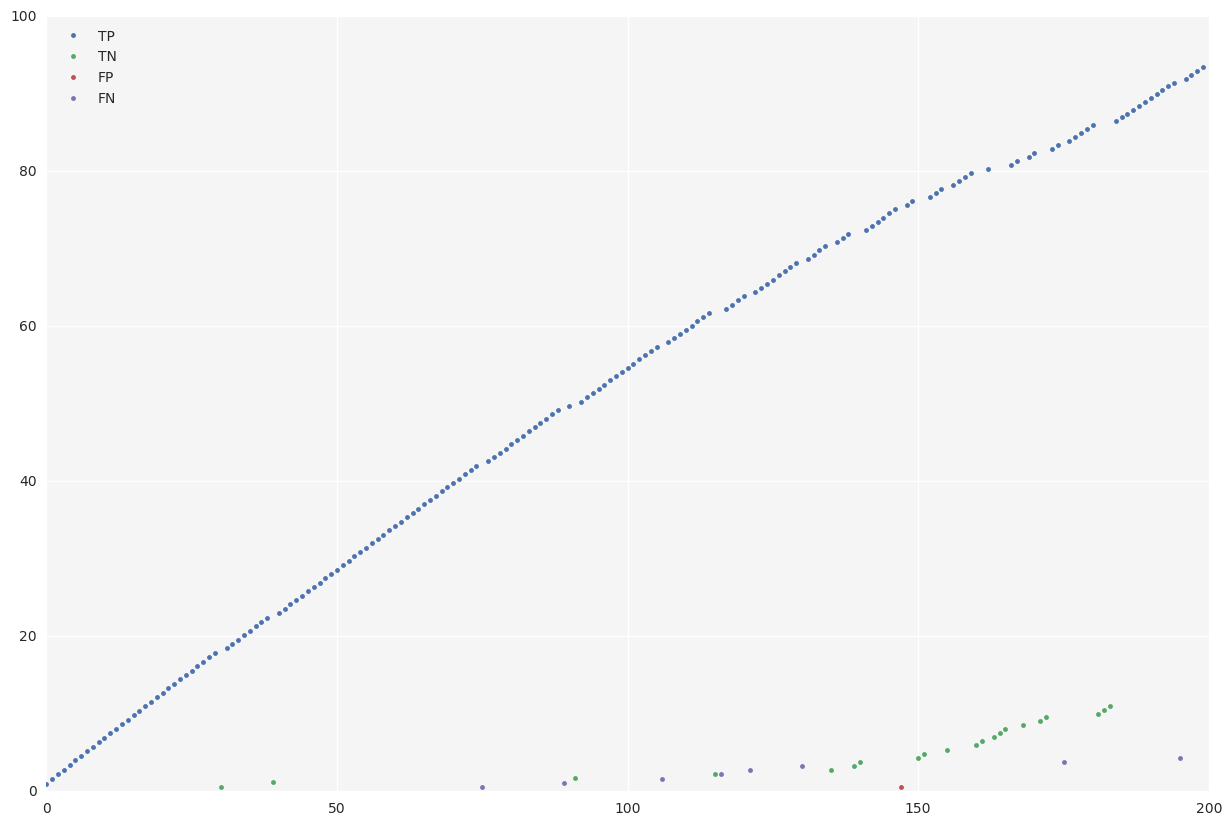

In [124]:
r = 200
x = np.arange(r)
weight_order = sample_weights.argsort()[::-1]

TP = (yhat == y_bin) & (y_bin == 1)
TP = TP[weight_order][:r]

TN = (yhat == y_bin) & (y_bin == 0)
TN = TN[weight_order][:r]

FP = (yhat != y_bin) & (yhat == 1)
FP = FP[weight_order][:r]

FN = (yhat != y_bin) & (yhat == 0)
FN = FN[weight_order][:r]

F = (yhat != y_bin)
F = F[weight_order][:r]

T = (yhat == y_bin)
T = T[weight_order][:r]

plt.figure(figsize = [15,10])
plt.plot(x[TP],sample_weights[weight_order][:r][TP].cumsum(),'.')
plt.plot(x[TN],sample_weights[weight_order][:r][TN].cumsum(),'.')
plt.plot(x[FP],sample_weights[weight_order][:r][FP].cumsum(),'.')
plt.plot(x[FN],sample_weights[weight_order][:r][FN].cumsum(),'.')
plt.legend(('TP','TN',"FP","FN"), loc = 2);

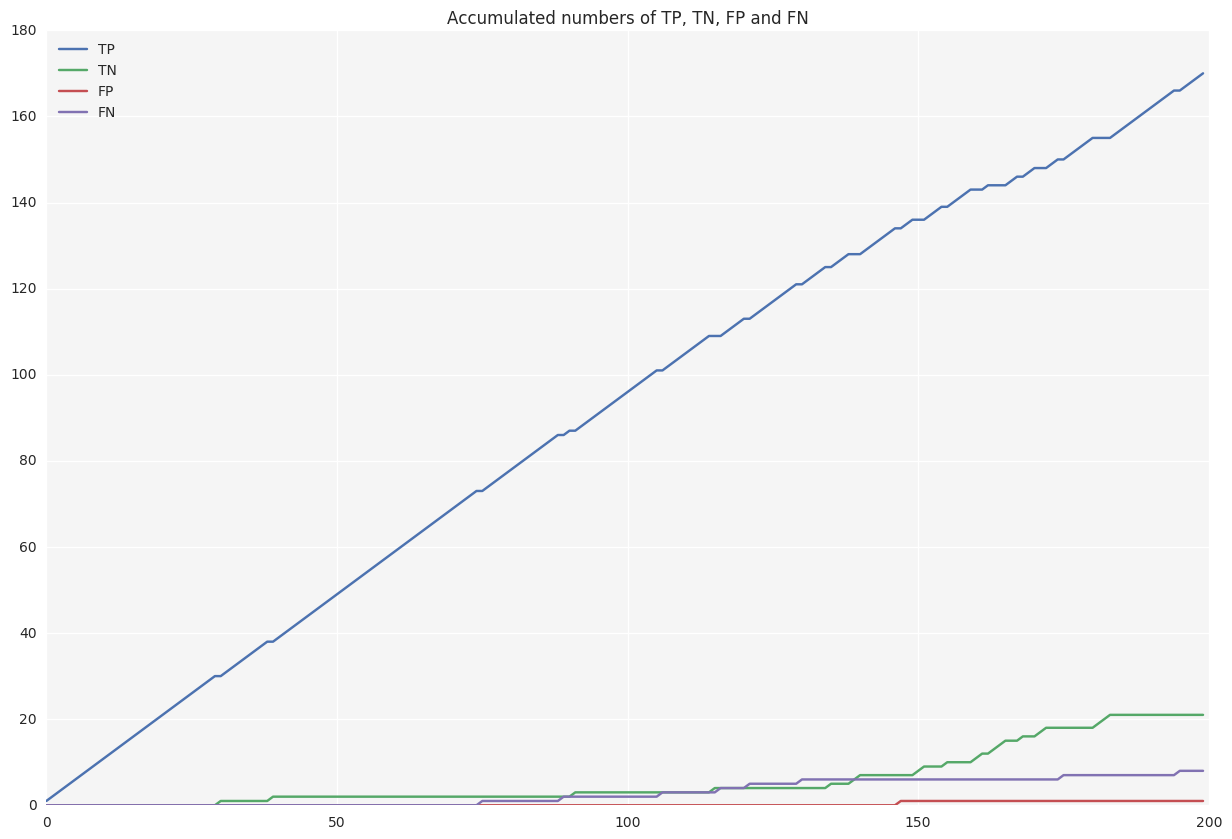

In [126]:
plt.figure(figsize = [15,10])
plt.plot(x,TP.cumsum())
plt.plot(x,TN.cumsum())
plt.plot(x,FP.cumsum())
plt.plot(x,FN.cumsum())
plt.legend(('TP','TN',"FP","FN"),loc=2)
plt.title('Accumulated numbers of TP, TN, FP and FN');

False predictions start at #75 sample weight


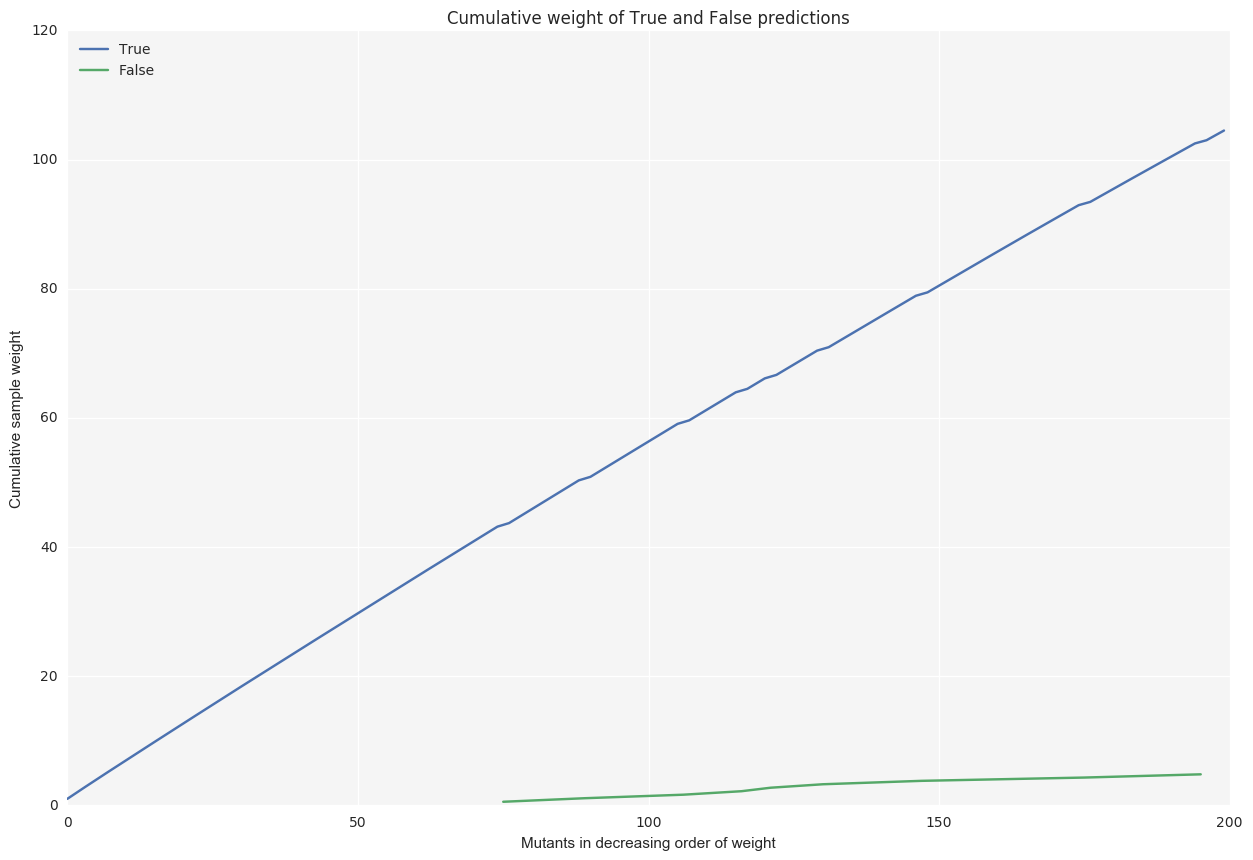

In [130]:
plt.figure(figsize=[15,10])
pT = plt.plot(x[T],sample_weights[weight_order][:r][T].cumsum())
pF = plt.plot(x[F],sample_weights[weight_order][:r][F].cumsum())
print 'False predictions start at #%d sample weight' % x[F][0]

plt.legend((pT[0], pF[0]), ('True','False'),loc=2)

plt.title("Cumulative weight of True and False predictions")
plt.ylabel("Cumulative sample weight")
plt.xlabel("Mutants in decreasing order of weight");

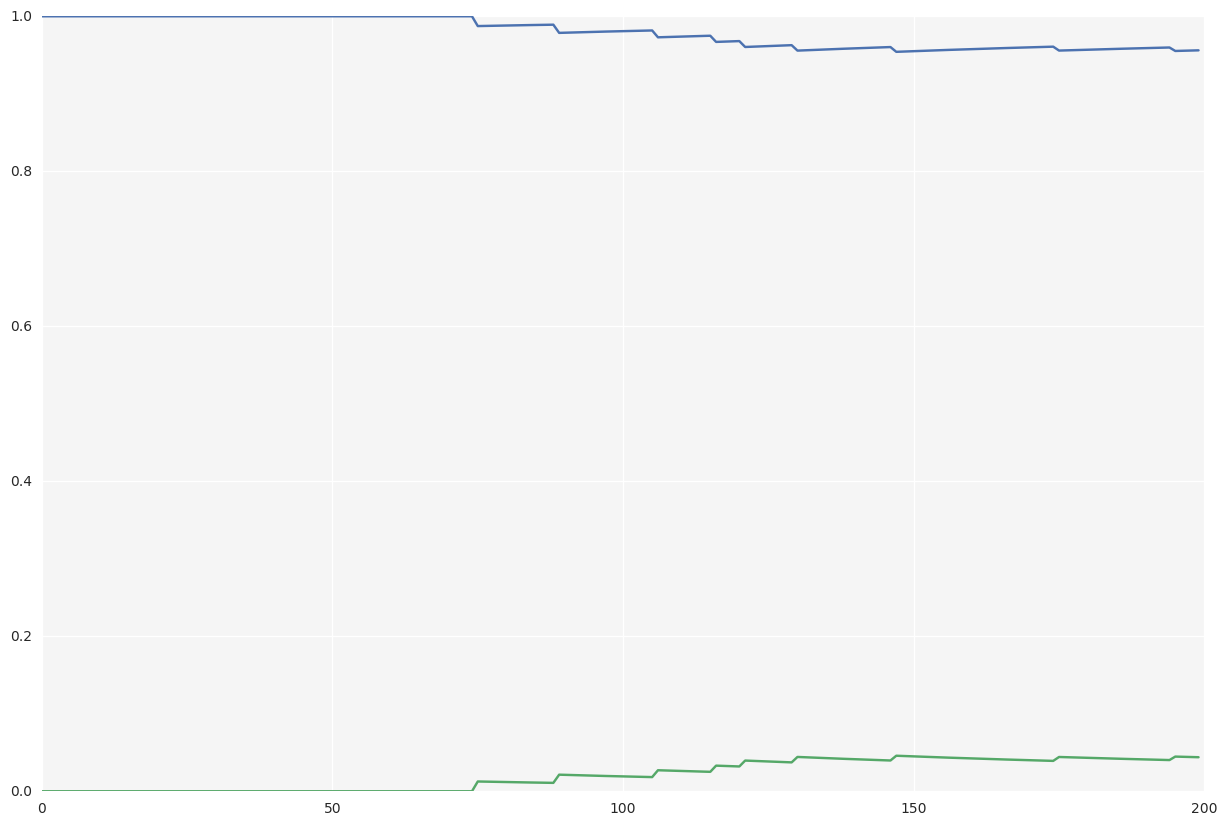

In [142]:
swT = sample_weights[weight_order][:r]
swT[x[~T]] = 0
swT = swT.cumsum()

swF = sample_weights[weight_order][:r]
swF[x[~F]] = 0
swF = swF.cumsum()

plt.figure(figsize = [15,10])
plt.plot(swT/(swF+swT))
plt.plot(swF/(swF+swT))
plt.title('Samples weights ')

del swF,swT

# Predicted mutations

In [148]:
t1 = time()
single_mutants_idx = np.asarray((np.sum(X,axis = 1) == 1)).ravel()
single_mutation_idx = np.asarray(np.sum(X[single_mutants_idx,:],axis=0) == 1).ravel()
single_mutation_idx
del single_mutants_idx

S = sparse.diags(np.ones(X.shape[1]))
ys = clf.predict(S)
hs = clf.predict_proba(S)
pos_idx = (hs[:,1]>0.9) & ~single_mutation_idx
neg_idx = (hs[:,0]>0.9) & ~single_mutation_idx
pos_mutations = zip([col_names[i] for i in xrange(pos_idx.shape[0]) if pos_idx[i]],hs[pos_idx][:,1],np.sum(X[:,pos_idx],axis = 0).tolist()[0])
neg_mutations = zip([col_names[i] for i in xrange(neg_idx.shape[0]) if neg_idx[i]],hs[neg_idx][:,0],np.sum(X[:,neg_idx],axis = 0).tolist()[0])
print len(pos_mutations),len(neg_mutations)
print time()-t1


418 92
0.369290113449


In [149]:
pos_mutations.sort(key=lambda x:x[2],reverse = True)
neg_mutations.sort(key=lambda x:x[2],reverse = True)
pos_mutations[:20]

[('SN210H', 0.99049052973069995, 79L),
 ('ST184I', 0.9637050065631535, 74L),
 ('SN103T', 0.99134997529460689, 39L),
 ('SD232A', 0.96782234560124758, 39L),
 ('SK156T', 0.98483480816103586, 35L),
 ('SI227S', 0.97553724096256944, 34L),
 ('SK124T', 0.97172474031000478, 33L),
 ('SA152G', 0.98080278109712937, 31L),
 ('SE32D', 0.91935961854529169, 31L),
 ('SD19E', 0.98294335602601424, 29L),
 ('SL13M', 0.93314736132326381, 29L),
 ('SQ202K', 0.94033649842563938, 27L),
 ('SK154N', 0.95911633677842334, 26L),
 ('SQ182H', 0.96018531611206925, 26L),
 ('SR107L', 0.98553355076188287, 25L),
 ('SP87T', 0.92643969832316464, 25L),
 ('SE233*', 0.90629270242652737, 24L),
 ('SD232E', 0.99086427670095367, 24L),
 ('SD19Y', 0.97889594578703365, 24L),
 ('SD188E', 0.97521090416942224, 22L)]

In [135]:
t1 = time()
# predict the category for all possible single mutations available in the dataset
pos_mutations = {}
neg_mutations = {}
count = 0
for i in clf.feature_importances_.argsort()[::-1]:
    if col_names[i] not in single_mutations:
        occurence = X[:,i].sum()
        #med_brigtness = np.median(y[X[:,i]>0])
        mutation_vector = np.zeros((1,X.shape[1]))
        mutation_vector[0,i] = 1
        h = clf.predict_proba(mutation_vector)
        #print h
        if h[0,1] > 0.9:
            pos_mutations[col_names[i]] = (h[0][1],occurence,count)
            #print count,col_names[i],clf.feature_importances_[i]
            #print h
        if h[0,0] > 0.9:
            neg_mutations[col_names[i]] = (h[0][0],occurence,count)
    count += 1
   
plt.plot(np.sort(clf.feature_importances_)[::-1],".")
print time()-t1

AttributeError: 'GridSearchCV' object has no attribute 'feature_importances_'

In [282]:
pos_mutations['SE88Q']

(1.0, 6, 1749)

In [11]:
# checking the prediction of classifier on provided set of mutants with single mutations
count = 0
for mutation in single_mutations:
    index = single_mutations[mutation]["id"]
    mutation_vector = np.zeros((1,X.shape[1]))
    mutation_vector[0,index] = 1
    yhat = clf.predict(mutation_vector)
    h = clf.predict_proba(mutation_vector)
    for mutant in single_mutations[mutation]["mutants"]:
        if yhat == y_bin[mutant]:
            count += 1
        else:
            print "%d %d %.2f %.2f" %(yhat[0],y_bin[mutant],h[0][int(yhat[0])],y[mutant]/y[0])

#print "\nFraction of correct single mutation predictions %.2f" % (count*1./len(single_mutations.keys()))

NameError: name 'single_mutations' is not defined

In [232]:
for i in clf.feature_importances_.argsort()[::-1][:10]:
    print i,clf.feature_importances_[i]

97 0.0143104006796
24 0.0133195461577
80 0.0126326680093
118 0.0120769823474
82 0.011288892046
54 0.00960766825015
26 0.00947245560247
215 0.00942723966379
85 0.00910806818382
71 0.0090743748663


In [10]:
clf = DecisionTreeClassifier(min_samples_split=20)
clf.fit(X_comb,y_bin)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=20, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [84]:
svd = TruncatedSVD(100)
Y = svd.fit_transform(X_loc_aa)
print Y.shape

(54025, 100)


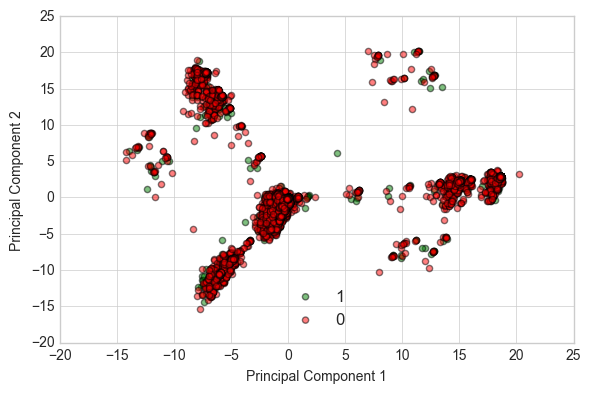

In [107]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(6, 4))
    for lab, col in zip((1, 0),
                        ('green', 'red')):
        plt.scatter(Y[y_bin==lab, 1],
                    Y[y_bin==lab, 2],
                    label=lab,
                    c=col,alpha = 0.5)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(loc='lower center')
    plt.tight_layout()
    plt.show()

In [50]:
#print svd.explained_variance_ratio_.sum()
#eig_pairs = [(svd.explained_variance_ratio_[i],i) for i in range(svd.n_components)]
#eig_pairs.sort(key=lambda x:x[0],reverse=True)
#for i in range(len(eig_pairs)):
 #   print eig_pairs[i][0],eig_pairs[i][1]

In [51]:
#plt.plot(svd.components_[1])
#print np.abs(svd.components_[1]).argsort()[::-1][:10]

### Applying SVC

In [151]:
skf = StratifiedKFold(n_splits=5,shuffle=True)
train_idx,test_idx = skf.split(X,y_bin).next()
test_idx.shape
x,y = X[test_idx,:],y_bin[test_idx]
x.shape
test_idx

array([    7,    15,    16, ..., 54018, 54020, 54023])

In [95]:
print "Running SVM parameter grid search..."
t1 = time()
clf = SVC(class_weight={0:class_weights[0],1:class_weights[1]})
#print rf.get_params()
parameters = {"C":(.1,10,100),"gamma":(0.01,.1,1)}
clf = GridSearchCV(clf,param_grid=parameters,cv = 5,n_jobs=-1,\
                   fit_params={'sample_weight':sample_weights[test_idx]})
clf.fit(x,y)
print "Time taken: %.f s"%(time()-t1)

Running SVM...
Time taken: 217 s


In [96]:
print clf.best_params_,clf.best_score_
cv_results = pd.DataFrame(clf.cv_results_)
cv_results.sort_values(by="rank_test_score").sort_values(by="rank_test_score")
cv_results[['params',"mean_test_score","std_test_score",'rank_test_score','mean_fit_time']].sort_values(by="rank_test_score")

{'C': 100, 'gamma': 0.1} 0.794003331483


,params,mean_test_score,std_test_score,rank_test_score,mean_fit_time
7,"{u'C': 100, u'gamma': 0.1}",0.794003,0.016011,1,5.090356
8,"{u'C': 100, u'gamma': 1}",0.760689,0.017834,2,13.477114
4,"{u'C': 10, u'gamma': 0.1}",0.734407,0.017664,3,11.208999
5,"{u'C': 10, u'gamma': 1}",0.723950,0.009463,4,11.672227
6,"{u'C': 100, u'gamma': 0.01}",0.705071,0.026588,5,7.180618
3,"{u'C': 10, u'gamma': 0.01}",0.347307,0.001499,6,10.228948
0,"{u'C': 0.1, u'gamma': 0.01}",0.340552,0.000063,7,12.645110
1,"{u'C': 0.1, u'gamma': 0.1}",0.340552,0.000063,7,13.147998
2,"{u'C': 0.1, u'gamma': 1}",0.340552,0.000063,7,16.358358


In [155]:
# Running
print "Running SVM..."
t1 = time()
cv = StratifiedKFold(n_splits=3)
clf = SVC(C=100,gamma=0.1,class_weight={0:class_weights[0],1:class_weights[1]})
scores = cross_val_score(clf,X, y_bin, cv=cv,n_jobs = -1,fit_params={'sample_weight':sample_weights})
print "Time taken: %.f"%(time()-t1)

Running SVM...
Time taken: 274


In [159]:
def cross_validate(clf,X,y,fit_params=None,n_splits = 5):
    print "Running classifier cross-validation..."
    t1 = time()
    cv = StratifiedKFold(n_splits=n_splits)
    scores = cross_val_score(clf,X,y, cv=cv,n_jobs = -1,fit_params=fit_params)
    print "Time taken: %.f"%(time()-t1)
    return scores

In [156]:
clf = SVC(C=100,gamma=0.1,class_weight={0:class_weights[0],1:class_weights[1]})
scores = cross_validate(clf,fit_params={'sample_weight':sample_weights})    
print("Accuracy: %0.2f (+/- %0.3f)" % (scores.mean(), scores.std() * 2))

[ 0.85007496  0.85872945  0.87444469]
Accuracy: 0.86 (+/- 0.020)


In [149]:
# train the classifer using full data set
print "Training SVM..."
clf = SVC(C=100,gamma=0.1,class_weight={0:class_weights[0],1:class_weights[1]})
print clf.fit(X,y_bin,sample_weight = sample_weights)
print "Time taken: %.f"%(time()-t1)

Training SVM...
SVC(C=100, cache_size=200, class_weight={0: 0.51632097448707515, 1: 1.0},
  coef0=0.0, decision_function_shape=None, degree=3, gamma=0.1,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)
Time taken: 4006


In [150]:
print "Training Accuracy: %.2f"%metrics.accuracy_score(y_bin,clf.predict(X),sample_weight = sample_weights)

Training Accuracy: 0.97


### Applying SVC on blosum dataset

In [165]:
skf = StratifiedKFold(n_splits=5,shuffle=True)
train_idx,test_idx = skf.split(X_blosum_scaled,y_bin).next()
test_idx.shape
x,y = X_blosum_scaled[test_idx,:],y_bin[test_idx]
x.shape
test_idx

array([    2,     8,    11, ..., 54013, 54014, 54021])

In [167]:
# perform the grid search to find the best parameters
print "Running SVM grid search..."
t1 = time()
clf = SVC(class_weight={0:class_weights[0],1:class_weights[1]})
parameters = {"C":(10,110),"gamma":(1,.1)}
clf = GridSearchCV(clf,param_grid=parameters,cv = 5,n_jobs=-1,\
                   fit_params={'sample_weight':sample_weights[test_idx]})
clf.fit(x,y)
print "Time taken: %.f s"%(time()-t1)

Running SVM grid search...
Time taken: 81 s


In [168]:
# print 
print clf.best_params_,clf.best_score_
cv_results = pd.DataFrame(clf.cv_results_)
cv_results.sort_values(by="rank_test_score").sort_values(by="rank_test_score")
cv_results[['params',"mean_test_score","std_test_score",'rank_test_score','mean_fit_time']].sort_values(by="rank_test_score")

{'C': 110, 'gamma': 1} 0.74995372941


,params,mean_test_score,std_test_score,rank_test_score,mean_fit_time
2,"{u'C': 110, u'gamma': 1}",0.749954,0.006393,1,11.844177
0,"{u'C': 10, u'gamma': 1}",0.741347,0.014735,2,7.267414
3,"{u'C': 110, u'gamma': 0.1}",0.727466,0.015833,3,10.229941
1,"{u'C': 10, u'gamma': 0.1}",0.684620,0.021800,4,8.536337


In [166]:
clf = SVC(C=110,gamma=1,class_weight={0:class_weights[0],1:class_weights[1]})
scores = cross_validate(clf,x,y,fit_params={'sample_weight':sample_weights[test_idx]}) 
print scores
print("Accuracy: %0.2f (+/- %0.3f)" % (scores.mean(), scores.std() * 2))

Running classifier cross-validation...
Time taken: 17
[ 0.75115634  0.74317446  0.76029616  0.74317446  0.75196668]
Accuracy: 0.75 (+/- 0.013)


In [171]:
clf = SVC(C=110,gamma=1,class_weight={0:class_weights[0],1:class_weights[1]})
scores = cross_validate(clf,X_blosum_scaled,y_bin,n_splits=3,fit_params={'sample_weight':sample_weights})
print scores
print("Accuracy: %0.2f (+/- %0.3f)" % (scores.mean(), scores.std() * 2))

Running classifier cross-validation...
Time taken: 506
[ 0.76794936  0.77060195  0.76921368]
Accuracy: 0.77 (+/- 0.002)


In [187]:
# train the classifer using full data set
print "Training SVM..."
t1 = time()
clf = SVC(C=110,gamma=1,class_weight={0:class_weights[0],1:class_weights[1]},max_iter=15000)
print clf.fit(X_blosum_scaled,y_bin,sample_weight = sample_weights)
print "Time taken: %.f"%(time()-t1)

Training SVM...
SVC(C=110, cache_size=200, class_weight={0: 0.51632097448707515, 1: 1.0},
  coef0=0.0, decision_function_shape=None, degree=3, gamma=1, kernel='rbf',
  max_iter=15000, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Time taken: 79


/Users/tiavlovskiegor/anaconda2/lib/python2.7/site-packages/sklearn/svm/base.py:220: ConvergenceWarning: Solver terminated early (max_iter=15000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


In [186]:
print "Training Accuracy: %.2f"%metrics.accuracy_score(y_bin,clf.predict(X_blosum_scaled),sample_weight = sample_weights)

Training Accuracy: 0.82


In [178]:
X_blosum_scaled.min()

-1.0

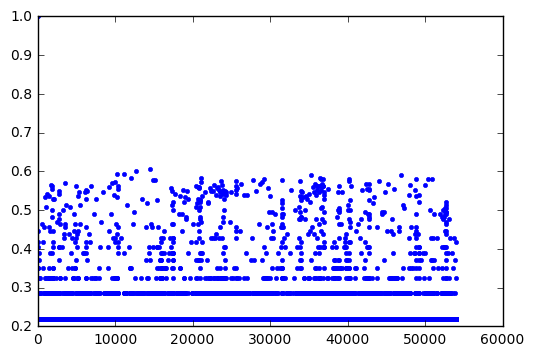

In [6]:
plt.plot(sample_weights,".")